In [1]:
import os, io
import json
import gzip
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.base import BaseEstimator
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold


import sklearn
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tarfile

In [2]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/All_Beauty.json.gz -P datasets
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/AMAZON_FASHION.json.gz -P datasets
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Software.json.gz -P datasets

--2021-05-14 18:11:59--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47350910 (45M) [application/octet-stream]
Saving to: ‘datasets/All_Beauty.json.gz’

All_Beauty.json.gz  100%[===================>]  45.16M  29.6MB/s    in 1.5s    

2021-05-14 18:12:01 (29.6 MB/s) - ‘datasets/All_Beauty.json.gz’ saved [47350910/47350910]

--2021-05-14 18:12:01--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/AMAZON_FASHION.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93185167 (89M) [application/octet-stream]
Saving to: ‘datasets/AMAZON_FASHION.json.gz’

AMAZON_FASHION.json 100%[===================>]  88

In [3]:
data = []
with gzip.open('datasets/All_Beauty.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
with gzip.open('datasets/AMAZON_FASHION.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
with gzip.open('datasets/Software.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

In [4]:
print(data[1])

{'overall': 4.0, 'verified': True, 'reviewTime': '12 18, 2014', 'reviewerID': 'A2F5GHSXFQ0W6J', 'asin': '0143026860', 'reviewerName': 'Mary K. Byke', 'reviewText': "My  husband wanted to reading about the Negro Baseball and this a great addition to his library\n Our library doesn't haveinformation so this book is his start. Tthank you", 'summary': "... to reading about the Negro Baseball and this a great addition to his library Our library doesn't haveinformation so ...", 'unixReviewTime': 1418860800}


In [5]:
newdata = []
counter_1 = 0
counter_2 = 0
counter_3 = 0
counter_4 = 0
counter_5 = 0
MAX_TRAIN = 1500
MIN_SENTENCE_LENGTH = 0
MAX_SENTENCE_LENGTH = 25
np.random.seed(42)
indices = np.random.permutation(len(data))

for ind in indices:
        i = data[ind]
        try:
            t = i['reviewText']
            revlabel = []
            if (i['overall'] == 1 and counter_1+counter_2<MAX_TRAIN  and len(t.split(' '))>MIN_SENTENCE_LENGTH and len(t.split(' '))<MAX_SENTENCE_LENGTH):
                counter_1 += 1
                textPos = i['reviewText']
                revlabel.append(textPos)
                revlabel.append(0)
                newdata.append(revlabel)
            elif (i['overall'] == 2 and counter_2+counter_1<MAX_TRAIN  and len(t.split(' '))>MIN_SENTENCE_LENGTH and len(t.split(' '))<MAX_SENTENCE_LENGTH):
                counter_2 += 1
                textPos = i['reviewText']
                revlabel.append(textPos)
                revlabel.append(0)
                newdata.append(revlabel)
            elif (i['overall'] == 3 and counter_3<MAX_TRAIN/3  and len(t.split(' '))>MIN_SENTENCE_LENGTH and len(t.split(' '))<MAX_SENTENCE_LENGTH):
                counter_3 += 1
                textPos = i['reviewText']
                revlabel.append(textPos)
                revlabel.append(1)
            elif (i['overall'] == 4 and counter_4+counter_5<MAX_TRAIN  and len(t.split(' '))>MIN_SENTENCE_LENGTH and len(t.split(' '))<MAX_SENTENCE_LENGTH):
                counter_4 += 1
                textPos = i['reviewText']
                revlabel.append(textPos)
                revlabel.append(1)
                newdata.append(revlabel)
            elif (i['overall'] == 5 and counter_5+counter_4<MAX_TRAIN  and len(t.split(' '))>MIN_SENTENCE_LENGTH and len(t.split(' '))<MAX_SENTENCE_LENGTH):
                counter_5 += 1
                textPos = i['reviewText']
                revlabel.append(textPos)
                revlabel.append(1)
                newdata.append(revlabel)
        except:
            continue

In [6]:
df_amazon = pd.DataFrame(newdata, columns=['reviewText', 'label'])
df_amazon.head
df_amazon.label.value_counts()

1    1500
0    1500
Name: label, dtype: int64

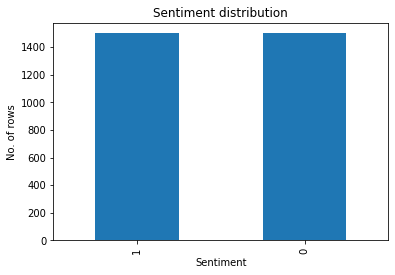

In [7]:
plt.figure()
pd.value_counts(df_amazon['label']).plot.bar(title="Sentiment distribution")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows")
plt.show()

In [8]:
punctuations = string.punctuation

nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

parser = English()

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    return mytokens

def clean_text(text):
    return text.strip().lower()

In [9]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [10]:
X = df_amazon['reviewText']
ylabels = df_amazon['label']
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3, random_state=42)

In [11]:
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]


    def fit(self, X, y=None, **fit_params):
        return self


    def get_params(self, deep=True):
        return {}

In [12]:
classifier = MultinomialNB()

In [13]:
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

In [14]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f5a13c620d0>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x7f5a14b35440>,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [15]:
predicted = pipe.predict(X_test)


print("Naive Bayes Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Naive Bayes Precision:",metrics.precision_score(y_test, predicted))
print("Naive Bayes Recall:",metrics.recall_score(y_test, predicted))

Naive Bayes Accuracy: 0.8622222222222222
Naive Bayes Precision: 0.8599562363238512
Naive Bayes Recall: 0.8675496688741722


In [16]:
classifier = LogisticRegression()

pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])


pipe.fit(X_train,y_train)
predicted = pipe.predict(X_test)


print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.8511111111111112
Logistic Regression Precision: 0.8977556109725686
Logistic Regression Recall: 0.7947019867549668


In [17]:
tempx=bow_vector.fit_transform(X_train)
tempx.shape

(2100, 2750)

In [18]:
print(tempx[78,:]>0)

  (0, 742)	True
  (0, 768)	True
  (0, 896)	True
  (0, 1123)	True
  (0, 1213)	True
  (0, 1416)	True
  (0, 1693)	True
  (0, 2138)	True
  (0, 2460)	True


In [19]:
from gensim.models import FastText
import gensim
import time
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.porter import PorterStemmer
import gensim.downloader as gendownload
porter_stemmer = PorterStemmer()
from tqdm.notebook import tqdm

In [20]:
df_amazon = pd.DataFrame(newdata, columns=['reviewText', 'rating'])
df_amazon.head
df_amazon['stop_w_rem'] = [remove_stopwords(line) for line in tqdm(df_amazon['reviewText'])]
df_amazon['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in tqdm(df_amazon['stop_w_rem'])]
df_amazon.rating.value_counts()

1    1500
0    1500
Name: rating, dtype: int64

In [21]:

def split_train_test(df_amazon, test_size=0.3, shuffle_state=True):
   X_train, X_test, Y_train, Y_test = train_test_split(df_amazon[['tokenized_text']],
                                                       df_amazon['rating'],
                                                       shuffle=shuffle_state,
                                                       test_size=test_size,
                                                       random_state=42)
   print("Value counts for Train sentiments")
   print(Y_train.value_counts())
   print("Value counts for Test sentiments")
   print(Y_test.value_counts())
   print(type(X_train))
   print(type(Y_train))
   X_train = X_train.reset_index()
   X_test = X_test.reset_index()
   Y_train = Y_train.to_frame()
   Y_train = Y_train.reset_index()
   Y_test = Y_test.to_frame()
   Y_test = Y_test.reset_index()
   print(X_train.head())
   return X_train, X_test, Y_train, Y_test


X_train, X_test, Y_train, Y_test = split_train_test(df_amazon)


Value counts for Train sentiments
0    1053
1    1047
Name: rating, dtype: int64
Value counts for Test sentiments
1    453
0    447
Name: rating, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index                                     tokenized_text
0    611                          [exactly, look, pictures]
1    530  [purchased, employees, they, understand, qb, l...
2   2787      [scratched, up, used, didn, order, use, case]
3     49          [payed, yrs, got, month, days, left, why]
4   1883  [cheaply, made, sent, daughter, law, quit, bit...


In [22]:

DIM_SIZE = 100
start_time = time.time()
train_text = pd.Series(df_amazon['tokenized_text']).values
ft_model = FastText(train_text, min_count = 1, size = DIM_SIZE, workers = 20, window = 5, sg = 1, iter = 5)
print("Time taken to train FastText model: " + str(time.time() - start_time))


#To download a pre-trainedmodel of size 300, run the below command
#ft_model = gendownload.load("fasttext-wiki-news-subwords-300")


Time taken to train FastText model: 1.6959867477416992


In [23]:
ft_filename = 'train_review_ft.csv'
open('ft_filename','w').close()
with open(ft_filename, 'w+') as ft_file:
   for index, row in tqdm(X_train.iterrows()):
       vec = np.zeros(DIM_SIZE,)
       count = 0
       for token in row['tokenized_text']:
           try:
               vec+=ft_model[token]
               count+=1
           except:
               pass

       vec = vec/(max(1,count))

       model_vector = vec.tolist()

       if index == 0:
           header = ",".join(str(ele) for ele in range(DIM_SIZE))
           ft_file.write(header)
           ft_file.write("\n")
       if type(model_vector) is list: 
           line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
       else:
           line1 = ",".join([str(0) for i in range(DIM_SIZE)])
       ft_file.write(line1)
       ft_file.write('\n')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [24]:

test_features_ft = []


start_time = time.time()


for index, row in tqdm(X_test.iterrows()):
   vec = np.zeros(DIM_SIZE,)
   count = 0
   for token in row['tokenized_text']:
       try:
           vec+=ft_model[token]
           count+=1
       except:
           continue
   vec = vec/(max(1,count))


   model_vector = vec.tolist()


   if type(model_vector) is list:
       test_features_ft.append(model_vector)
   else:
       test_features_ft.append(np.array([0 for i in range(DIM_SIZE)]))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [25]:
ft_df = pd.read_csv(ft_filename, escapechar='\\')
print(len(ft_df.to_numpy()))
print(len(Y_train))
print(len(test_features_ft))
print(len(Y_test))

2100
2100
900
900


In [26]:
#Define the models
clf_lr_ft = LogisticRegression(max_iter=200)
clf_gnb_ft = GaussianNB()


#Fit the Linear regression Model
start_time = time.time()
clf_lr_ft.fit(ft_df, Y_train['rating'])
print("Time taken to fit the LR model with FastText vectors: " + str(time.time() - start_time))


#Fit the Naive Bayes model
start_time = time.time()
clf_gnb_ft.fit(ft_df, Y_train['rating'])
print("Time taken to fit the GNB model with FastText vectors: " + str(time.time() - start_time))


#Test the models
start_time = time.time()
test_predictions_ft_lr = clf_lr_ft.predict(test_features_ft)
test_predictions_ft_gnb = clf_gnb_ft.predict(test_features_ft)


print("Time taken to predict with FastText vectors: " + str(time.time() - start_time))

print("Naive Bayes Regression Accuracy:",metrics.accuracy_score(Y_test['rating'],test_predictions_ft_gnb))
print("Naive Bayes Regression Precision:",metrics.precision_score(Y_test['rating'],test_predictions_ft_gnb))
print("Naive Bayes Regression Recall:",metrics.recall_score(Y_test['rating'],test_predictions_ft_gnb))

print("Logistic Regression Accuracy:",metrics.accuracy_score(Y_test['rating'],test_predictions_ft_lr))
print("Logistic Regression Precision:",metrics.precision_score(Y_test['rating'],test_predictions_ft_lr))
print("Logistic Regression Recall:",metrics.recall_score(Y_test['rating'],test_predictions_ft_lr))


Time taken to fit the LR model with FastText vectors: 0.01974797248840332
Time taken to fit the GNB model with FastText vectors: 0.00445866584777832
Time taken to predict with FastText vectors: 0.013940572738647461
Naive Bayes Regression Accuracy: 0.54
Naive Bayes Regression Precision: 0.5314009661835749
Naive Bayes Regression Recall: 0.7284768211920529
Logistic Regression Accuracy: 0.5377777777777778
Logistic Regression Precision: 0.537525354969574
Logistic Regression Recall: 0.5849889624724062


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.optim import Adam, SGD

In [28]:
class DeepLayer(nn.Module):
   def __init__(self, inputDimension, outputDimension ):


       super(DeepLayer,self).__init__()


       self.inputDimension = inputDimension
       self.outputDimension = outputDimension
       self.layer_multiplier = 2
# Define the linear parts of each layer. Please note we need a different definition for each layer
       self.linear_in =nn.Linear(self.inputDimension, self.inputDimension * self.layer_multiplier, bias = True).cuda()
       self.linear_hidden1 = nn.Linear(self.inputDimension  * self.layer_multiplier, self.inputDimension * self.layer_multiplier, bias = True).cuda()
       self.linear_hidden2 = nn.Linear(self.inputDimension  * self.layer_multiplier, self.inputDimension * self.layer_multiplier, bias = True).cuda()
       self.linear_out = nn.Linear(self.inputDimension  * self.layer_multiplier, self.outputDimension, bias = True).cuda()
# Define their respective non-linear activations
       self.nonLinear1 = nn.ReLU().cuda()
       self.nonLinear2 = nn.ReLU().cuda()
       self.nonLinear3 = nn.ReLU().cuda()


# Define dropout wrappers
       self.dropout_rate = 0.5
       self.drop1 = nn.Dropout(p=self.dropout_rate)
       self.drop2 = nn.Dropout(p=self.dropout_rate)
       self.drop3 = nn.Dropout(p=self.dropout_rate)


# Make sure all linear layers are initialised randomly
       nn.init.xavier_normal_(self.linear_in.weight)
       #print(self.linear_in.weight)
       nn.init.xavier_normal_(self.linear_out.weight)
       #print(self.linear_out.weight)
       nn.init.xavier_normal_(self.linear_hidden1.weight)
       #print(self.linear_hidden1.weight)
       nn.init.xavier_normal_(self.linear_hidden2.weight)
       #print(self.linear_hidden2.weight)


   def forward(self, x_in):
# Define the forward pass function
       output = self.linear_out(self.drop1(self.nonLinear3(self.linear_hidden2(self.drop2(self.nonLinear2(self.linear_hidden1(self.drop3(self.nonLinear1(self.linear_in(x_in))))))))))

       return output

In [29]:
class FFNN(nn.Module):
   def __init__(self, inputDimension, outputDimension):
       super(FFNN,self).__init__()


       self.inputDimension = inputDimension
       self.outputDimension = outputDimension


       self.layer = DeepLayer(self.inputDimension, self.outputDimension)


# define Loss. As it is a binary classifier, we use binary cross entropyloss
# In case of multi-class, use Cross Entropy loss instead
       self.bce_loss = nn.BCEWithLogitsLoss()
       self.sigmoid = nn.Sigmoid()


   def loss(self, x, y):


       outputScores = self.layer(x)
       loss = self.bce_loss(outputScores, y)
# since our output is probability of the example belonging to class 1, we wrap a sigmoid function around the output layer. If using multiclass, use a softmax function instead
       prob_output = self.sigmoid(outputScores)
       return loss, prob_output, y


   def forward(self, x):


       outputScores = self.layer(x)
       prob_output = self.sigmoid(outputScores)

       return prob_output

In [30]:
def batch(iterable1, iterable2 , n=1):
   l = len(iterable1)
   for ndx in range(0, l, n):
       yield iterable1[ndx:min(ndx + n, l)], iterable2[ndx:min(ndx + n, l)]



In [31]:
# Get training and test examples ready
X_tr = ft_df.to_numpy()
X_te = np.asarray(test_features_ft)
Y_tr = Y_train.to_numpy()[:,1]
Y_te = Y_test.to_numpy()[:,1]


# Initialise performance metrics
precision = 0
recall = 0
fscore = 0


# Initialise training parameters
initial_lr = 0.1
input_dimensions=len(X_tr[0])
output_dimensions=1
NUM_EPOCHS = 50
BATCH_SIZE = 80


# Initialize FFNN
ff_nn = FFNN(input_dimensions,output_dimensions)


# Start training
for epoch in tqdm(range(1, NUM_EPOCHS)):
   # update learning rate and optimizer params
   lrate = initial_lr * np.exp(-0.1 * epoch)
   optim = SGD(ff_nn.parameters(), lr=lrate, momentum=0.04, weight_decay=0.0, nesterov=True)
   for inputs, labels in batch(X_tr, Y_tr, BATCH_SIZE):

       input_tensor = torch.from_numpy(inputs).cuda().float()
       output_tensor = torch.FloatTensor(labels).cuda().unsqueeze(1)


       optim.zero_grad()
       loss, _, _ = ff_nn.loss(input_tensor, output_tensor)


       loss.backward()
       optim.step()


# Training is over, now, let us start eval

In [32]:
ff_nn.eval()
true = []
predicted = []


for inputs, labels in batch(X_te, Y_te, BATCH_SIZE):
   input_tensor = torch.from_numpy(inputs).cuda().float()
   true_labels = []
   for i in range(labels.shape[0]):
       true_labels.append(int(labels[i]))
   true.extend(true_labels)


   optim.zero_grad()
   pred_labels = ff_nn.forward(input_tensor)
   pred_output = pred_labels.data.cpu().numpy()
   pred = []


   for i in range(len(pred_output)):
       # If output is above 0.5, we say the predicted label is 1, else 0
       if pred_output[i] >= 0.5:
           pred.append(1)
       else:
           pred.append(0)
   predicted.extend(pred)


precision = precision_score(true, predicted, average='weighted')
recall = recall_score(true, predicted, average='weighted')
fscore = f1_score(true, predicted, average='weighted')
print("Logistic Regression Accuracy:",metrics.accuracy_score(true,predicted))
print("Logistic Regression Precision:",precision)
print("Logistic Regression Recall:",recall)


Logistic Regression Accuracy: 0.5244444444444445
Logistic Regression Precision: 0.5245663492063493
Logistic Regression Recall: 0.5244444444444445
